# Player Insurance Scraper

This notebook will generate the CSV files for each player season. It will also run the hedging analysis of our proposed contracts.

## Step 1: scraping the data

<b>Goal: get usable player data that we can feed into our analysis in subsequent steps</b>

In order to run our analysis, we first need a matrix of available player data. The key should be on (player, season) and contain the following variables:
<li>Counting stats: points, rebounds, assists, turnovers, steals, blocks</li>
<li>Team played for during that season: list with possibly several values</li>
<li>Salary for that year: float</li>
<li>Salary rank for that year: int </li>
<li>Games played that year: list of 82 games, which will be represented as booleans (false if inactive, true if active)</li>

### A: pre-processing
Import the relevant libraries.

In [15]:
import requests
from bs4 import BeautifulSoup, Comment
import pandas as pd
import os
import lxml
import tqdm
import matplotlib.pyplot as plt

We also write a quick helper function to convert the string value of a salary into a Decimal that can be sorted.

In [16]:
#This function will turn salary into a number. Included in this code block is a test to ensure validity.
from re import sub
from decimal import Decimal
def makeDollarFloat(salary_str):
    return Decimal(sub(r'[^\d.]', '', salary_str))

#Test it on a salary
makeDollarFloat('$7,000,345')

Decimal('7000345')

Final pre-processing step is to set a few variables for the model, including:
<li>A list of all team codes for URL construction</li>
<li>The year from which we want to start scraping</li>
<li>A parameter that defines the premium as % of player contract</li>

In [17]:
team_codes = ['ATL', 'NJN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
              'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOH', 'NYK',
              'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

starting_year = 2000
ending_year = 2021
premium_pct = .04

### B: scraping top 5 salaries
Disability insurance is only required for the top five players by salary on each team. In this section, we get the top five players (by salary) on each team in a given year, sorted into a pandas dataframe, with basic counting stats.

For clarity, this code will walk through an example of one team (the Sacramento Kings in the 2011-2012 season) to demonstrate how we're scraping this information.

First, we get the URL for the team, the content of the url, and then turn it into a soup for parsing.

In [18]:
url = 'https://www.basketball-reference.com/teams/BOS/2013.html'
page = requests.get(url)
#We're using the lxml parser to get comments, which is important for later.
soup = BeautifulSoup(page.text, 'lxml')

Using the general page for a team, we can build out the basic counting stats and later append the salary value. For this team, we set the variables team and year to 'SAC' and 2012, though in our larger loop these will be set programatically.

We also get the link to the gamelog for a player, which is important later.

In [19]:
# This will build the initial dataframe for a player based of of the /teams/[code]/year page
# Initially, we scrape the basic counting stats, and add the team/year as a column to differentiate
# for the same player on different teams.

per_game = soup.find(id="div_per_game")
team='BOS'
year=2013

# This is a list of stats we're trying to scrape
stats = ['player', 'pts_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g']

stats_list = [[td.getText() for td in per_game.findAll('td', {'data-stat': stat})] for stat in stats]

all_stats = pd.DataFrame(stats_list).T
all_stats.columns = stats

#Add the team and year column
all_stats['team'] = [team] * len(all_stats['player'])
all_stats['year'] = [year] * len(all_stats['player'])
all_stats['gamelog'] = [td['href'] for td in per_game.findAll(href=True) if 'gamelog' in td['href']]
all_stats['player_id'] = [item.split("/gamelog")[0] for item in all_stats['gamelog']]
all_stats = all_stats[['player', 'team', 'year', 'pts_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'gamelog', 'player_id']]
all_stats


,player,team,year,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,gamelog,player_id
0,Rajon Rondo,BOS,2013,13.7,5.6,11.1,1.8,0.2,3.9,/players/r/rondora01/gamelog/2013/,/players/r/rondora01
1,Paul Pierce,BOS,2013,18.6,6.3,4.8,1.1,0.4,2.8,/players/p/piercpa01/gamelog/2013/,/players/p/piercpa01
2,Kevin Garnett,BOS,2013,14.8,7.8,2.3,1.1,0.9,1.6,/players/g/garneke01/gamelog/2013/,/players/g/garneke01
3,Avery Bradley,BOS,2013,9.2,2.2,2.1,1.3,0.4,1.4,/players/b/bradlav01/gamelog/2013/,/players/b/bradlav01
4,Jeff Green,BOS,2013,12.8,3.9,1.6,0.7,0.8,1.6,/players/g/greenje02/gamelog/2013/,/players/g/greenje02
5,Brandon Bass,BOS,2013,8.7,5.2,1.0,0.5,0.8,1.0,/players/b/bassbr01/gamelog/2013/,/players/b/bassbr01
6,Jason Terry,BOS,2013,10.1,2.0,2.5,0.8,0.1,1.3,/players/t/terryja01/gamelog/2013/,/players/t/terryja01
7,Courtney Lee,BOS,2013,7.8,2.4,1.8,1.1,0.3,1.1,/players/l/leeco01/gamelog/2013/,/players/l/leeco01
8,Jordan Crawford,BOS,2013,9.1,2.7,2.5,0.4,0.1,1.6,/players/c/crawfjo02/gamelog/2013/,/players/c/crawfjo02
9,Jared Sullinger,BOS,2013,6.0,5.9,0.8,0.5,0.5,0.6,/players/s/sullija01/gamelog/2013/,/players/s/sullija01


Next, we get the salary for a player. The salary table is distinct from the counting stats table, so we have to scrape it separately and then merge.

In [20]:
#This gets the salaries for a player

#We have to do some pre-processing to get the comment that the salary data is in
#Since comments is not a clean structure, we have to loop through all comments
# to find the comment that has the
#id of "salaries2", store that as a separate variable, and then make a soup out of it

comments = soup.find_all(string=lambda text: isinstance(text, Comment))
#This loops through all comments
for c in comments:
    commentsoup = BeautifulSoup(c, 'lxml')
    #Check if the salaries2 id is in this comment, if so store in salaries
    salary_comment = commentsoup.findAll(id="salaries2")
    if salary_comment != []:
        salaries = salary_comment[0]

#Now, we make a second data frame that has "player, salary"
player_id = []
salary = []
for row in salaries.findAll('tr'):
    if row.findAll('td') and row.find(href=True):
        player_id.append(row.find(href=True)['href'].split(".")[0])
        salary.append(row.find('td', {'data-stat': 'salary'}).getText())
salary_stats = pd.DataFrame([player_id, salary]).T
salary_stats.columns = ['player_id', 'salary']
salary_stats
all_stats = all_stats.join(salary_stats.set_index('player_id'), on='player_id')
all_stats = all_stats.fillna("$0")
all_stats['salary'] = all_stats['salary'].apply(makeDollarFloat)
all_stats

,player,team,year,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,gamelog,player_id,salary
0,Rajon Rondo,BOS,2013,13.7,5.6,11.1,1.8,0.2,3.9,/players/r/rondora01/gamelog/2013/,/players/r/rondora01,11000000
1,Paul Pierce,BOS,2013,18.6,6.3,4.8,1.1,0.4,2.8,/players/p/piercpa01/gamelog/2013/,/players/p/piercpa01,16790345
2,Kevin Garnett,BOS,2013,14.8,7.8,2.3,1.1,0.9,1.6,/players/g/garneke01/gamelog/2013/,/players/g/garneke01,11566265
3,Avery Bradley,BOS,2013,9.2,2.2,2.1,1.3,0.4,1.4,/players/b/bradlav01/gamelog/2013/,/players/b/bradlav01,1630800
4,Jeff Green,BOS,2013,12.8,3.9,1.6,0.7,0.8,1.6,/players/g/greenje02/gamelog/2013/,/players/g/greenje02,8385000
5,Brandon Bass,BOS,2013,8.7,5.2,1.0,0.5,0.8,1.0,/players/b/bassbr01/gamelog/2013/,/players/b/bassbr01,6000000
6,Jason Terry,BOS,2013,10.1,2.0,2.5,0.8,0.1,1.3,/players/t/terryja01/gamelog/2013/,/players/t/terryja01,5000000
7,Courtney Lee,BOS,2013,7.8,2.4,1.8,1.1,0.3,1.1,/players/l/leeco01/gamelog/2013/,/players/l/leeco01,5000000
8,Jordan Crawford,BOS,2013,9.1,2.7,2.5,0.4,0.1,1.6,/players/c/crawfjo02/gamelog/2013/,/players/c/crawfjo02,1198680
9,Jared Sullinger,BOS,2013,6.0,5.9,0.8,0.5,0.5,0.6,/players/s/sullija01/gamelog/2013/,/players/s/sullija01,1306920


Finally, we sort by salary, and only keep the top five.

In [21]:
top_five = all_stats.sort_values(by='salary', ascending=False)[:5]
top_five

,player,team,year,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,gamelog,player_id,salary
1,Paul Pierce,BOS,2013,18.6,6.3,4.8,1.1,0.4,2.8,/players/p/piercpa01/gamelog/2013/,/players/p/piercpa01,16790345
2,Kevin Garnett,BOS,2013,14.8,7.8,2.3,1.1,0.9,1.6,/players/g/garneke01/gamelog/2013/,/players/g/garneke01,11566265
0,Rajon Rondo,BOS,2013,13.7,5.6,11.1,1.8,0.2,3.9,/players/r/rondora01/gamelog/2013/,/players/r/rondora01,11000000
4,Jeff Green,BOS,2013,12.8,3.9,1.6,0.7,0.8,1.6,/players/g/greenje02/gamelog/2013/,/players/g/greenje02,8385000
5,Brandon Bass,BOS,2013,8.7,5.2,1.0,0.5,0.8,1.0,/players/b/bassbr01/gamelog/2013/,/players/b/bassbr01,6000000


With the knowledge this works, we can now write a loop that uses the parameters we set in part A to get this information for every single team.

First, we want to get a list to all the links for an individual team or season.

In [22]:
ROOT_URL_TEAMS = 'https://www.basketball-reference.com/teams/'

def get_team_links(code, start_year, end_year):
    # Get the base team page
    url = ROOT_URL_TEAMS + code
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    # Get the links to a team's season
    hyper_links = [item.find('a').get('href') for item in soup.findAll('th', {'data-stat': 'season'}) if item.find('a')]
    # Get the numerical representation of the years
    years = [int(''.join([x for x in link if x.isdigit()])) for link in hyper_links]
    # Zip the two together
    links_with_years = list(zip(hyper_links, years))
    # Return only the links between the start and end year
    return [x[0] for x in links_with_years if x[1] >= start_year and x[1] <= end_year]

all_team_links = []
for team in tqdm.tqdm(team_codes):
    all_team_links += get_team_links(team, starting_year, ending_year)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.73it/s]


In [23]:
# Root URL to scrape
ROOT_URL = 'https://www.basketball-reference.com'

# Pandas dataframe that will hold the result for all teams
all_top_five = pd.DataFrame()

# Code that gets you the data frame for a given team, year
def get_top_five(soup, team, year):
    #print (team, year)
    per_game = soup.find(id="div_per_game")
    # This is a list of stats we're trying to scrape
    stats = ['player', 'pts_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g']
    
    stats_list = [[td.getText() for td in per_game.findAll('td', {'data-stat': stat})] for stat in stats]
    
    all_stats = pd.DataFrame(stats_list).T
    all_stats.columns = stats

    #Add the team and year column
    all_stats['team'] = [team] * len(all_stats['player'])
    all_stats['year'] = [year] * len(all_stats['player'])
    all_stats['gamelog'] = [td['href'] for td in per_game.findAll(href=True) if 'gamelog' in td['href']]
    all_stats['player_id'] = [item.split("/gamelog")[0] for item in all_stats['gamelog']]
    all_stats = all_stats[['player', 'team', 'year', 'pts_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'gamelog', 'player_id']]
    
    #This gets the salaries for a player

    #We have to do some pre-processing to get the comment that the salary data is in
    #Since comments is not a clean structure, we have to loop through all comments
    # to find the comment that has the
    #id of "salaries2", store that as a separate variable, and then make a soup out of it

    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    #This loops through all comments
    for c in comments:
        commentsoup = BeautifulSoup(c, 'lxml')
        #Check if the salaries2 id is in this comment, if so store in salaries
        salary_comment = commentsoup.findAll(id="salaries2")
        if salary_comment != []:
            salaries = salary_comment[0]

    #Now, we make a second data frame that has "player, salary"
    player_id = []
    salary = []
    for row in salaries.findAll('tr'):
        if row.findAll('td') and row.find(href=True):
            player_id.append(row.find(href=True)['href'].split(".")[0])
            salary.append(row.find('td', {'data-stat': 'salary'}).getText())
    salary_stats = pd.DataFrame([player_id, salary]).T
    salary_stats.columns = ['player_id', 'salary']
    all_stats = all_stats.join(salary_stats.set_index('player_id'), on='player_id')
    all_stats = all_stats.fillna("$0")
    all_stats['salary'] = all_stats['salary'].apply(makeDollarFloat)
   
    top_five = all_stats.sort_values(by='salary', ascending=False)[:5]
    return top_five

for link in tqdm.tqdm(all_team_links):
    split_link = link.split("/")
    team = split_link[2]
    year = split_link[3].split(".")[0]
    url = ROOT_URL + link
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    all_top_five = pd.concat([all_top_five, get_top_five(soup, team, year)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 655/655 [02:55<00:00,  3.73it/s]


Now we have the full list of all players who were top five in salaries for their team since the year 2000. To verify, we can double check that the Houston in 2014 players are identical to the example we calculated above.

In [10]:
all_top_five[(all_top_five["team"] == "HOU") & (all_top_five["year"] == "2014")]

,player,team,year,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,gamelog,player_id,salary
2,Dwight Howard,HOU,2014,18.3,12.2,1.8,0.8,1.8,3.2,/players/h/howardw01/gamelog/2014/,/players/h/howardw01,20513178
0,James Harden,HOU,2014,25.4,4.7,6.1,1.6,0.4,3.6,/players/h/hardeja01/gamelog/2014/,/players/h/hardeja01,13701250
4,Jeremy Lin,HOU,2014,12.5,2.6,4.1,1.0,0.4,2.5,/players/l/linje01/gamelog/2014/,/players/l/linje01,8374646
6,Ömer Aşık,HOU,2014,5.8,7.9,0.5,0.3,0.8,1.2,/players/a/asikom01/gamelog/2014/,/players/a/asikom01,8374646
5,Terrence Jones,HOU,2014,12.1,6.9,1.1,0.7,1.3,0.9,/players/j/joneste01/gamelog/2014/,/players/j/joneste01,1551840


To see the full value by salary, we simply specify the column to sort on and sort in descending order.

In [11]:
all_top_five.sort_values(by='salary', ascending=False)

,player,team,year,pts_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,gamelog,player_id,salary
0,Stephen Curry,GSW,2021,32.0,5.5,5.8,1.2,0.1,3.4,/players/c/curryst01/gamelog/2021/,/players/c/curryst01,43006362
2,Chris Paul,PHO,2021,16.4,4.5,8.9,1.4,0.3,2.2,/players/p/paulch01/gamelog/2021/,/players/p/paulch01,41358814
0,Russell Westbrook,WAS,2021,22.2,11.5,11.7,1.4,0.4,4.8,/players/w/westbru01/gamelog/2021/,/players/w/westbru01,41358814
3,John Wall,HOU,2021,20.6,3.2,6.9,1.1,0.8,3.5,/players/w/walljo01/gamelog/2021/,/players/w/walljo01,41254920
0,James Harden,BRK,2021,24.6,8.5,10.9,1.3,0.8,4.0,/players/h/hardeja01/gamelog/2021/,/players/h/hardeja01,41254920
...,...,...,...,...,...,...,...,...,...,...,...,...
1,Primož Brezec,CHA,2005,13.0,7.4,1.2,0.5,0.8,1.5,/players/b/brezepr01/gamelog/2005/,/players/b/brezepr01,1554326
5,Terrence Jones,HOU,2014,12.1,6.9,1.1,0.7,1.3,0.9,/players/j/joneste01/gamelog/2014/,/players/j/joneste01,1551840
7,Dickey Simpkins,CHI,2000,4.2,5.4,1.4,0.3,0.3,1.9,/players/s/simpkdi01/gamelog/2000/,/players/s/simpkdi01,1500000
11,Michael Doleac,ORL,2000,7.0,4.1,0.8,0.4,0.4,0.8,/players/d/doleami01/gamelog/2000/,/players/d/doleami01,1357320


With the boring stuff out of the way, we can take a look at some of the actual numbers in this early stage. The graph below shows the sum of all top five salaries per team each year. Unsurprisingly, the number has trended upward as total salaries have increased, with noticeable jumps after CBA renegotiations.

<AxesSubplot:xlabel='year'>

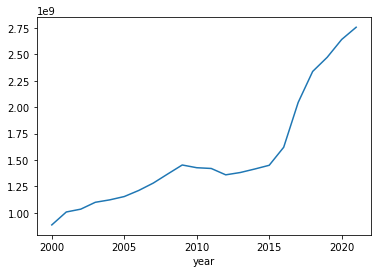

In [12]:
salary_by_year = all_top_five.groupby(by='year').sum()
salary_by_year['salary'].astype('float').plot()

To get more granular, let's look at the same data as the chart above in table form. The underlying size of the market for all disability insurance in 2021 appears to be ~2.75b.

In [24]:
all_top_five.groupby(by='year').sum()['salary']

year
2000     884886172
2001    1007366600
2002    1034289861
2003    1099171086
2004    1122201713
2005    1153615579
2006    1211339218
2007    1281040087
2008    1367453521
2009    1452535015
2010    1426705422
2011    1419571255
2012    1359327493
2013    1381063578
2014    1414242412
2015    1449734970
2016    1620360749
2017    2045148632
2018    2338669327
2019    2472387930
2020    2641205313
2021    2757265906
Name: salary, dtype: object

The final step is generating a CSV out of the data, which is fairly easy with Pandas. We specify only the player, team, year, and salary columns to save space.

In [27]:
all_top_five[['player', 'team', 'year', 'salary']].to_csv('top_five_salaries.csv', index=False)